## LOBSTER Anomaly Detection: LSTM Autoencoder (Reconstruction-Based)

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [5]:
WINDOW_SIZE = 25
FEATURES = ["price", "ask_price1", "bid_price1", "spread", "imbalance", "SMA_ask_price", "SMA_bid_price"]
EPOCHS = 50
BATCH_SIZE = 128

In [32]:
import json
import os
from datetime import datetime

def get_model_summary(model):
    summary = []
    for layer in model.layers:
        layer_type = layer.__class__.__name__
        config = layer.get_config()
        
        units = config.get("units") or config.get("filters") or config.get("pool_size") or "N/A"
        
        summary.append({
            "layer_type": layer_type,
            "units": units
        })
    return summary

def save_model_metadata(history, model, model_id, hyperparams=None, callbacks=None, log_path='models/model_log.json'):
    '''
    Save training history, model architecture, and metadata to a single JSON file.

    Args:
        history (tf.keras.callbacks.History): Keras training history.
        model (tf.keras.Model): Trained Keras model.
        model_id (str): Unique identifier for the model.
        hyperparams (dict): Dictionary of hyperparameters used in training.
        callbacks (list): List of callbacks used during training (optional).
        log_path (str): Path to the JSON log file.
    '''

    final_loss = history.history['loss'][-1]
    final_val_loss = history.history.get('val_loss', [None])[-1]

    callback_info = []
    if callbacks:
        for cb in callbacks:
            cb_type = type(cb).__name__
            if cb_type == "EarlyStopping":
                cb_dict = {
                    "type": cb_type,
                    "monitor": cb.monitor,
                    "patience": cb.patience,
                    "restore_best_weights": cb.restore_best_weights
                }
            elif cb_type == "ReduceLROnPlateau":
                cb_dict = {
                    "type": cb_type,
                    "monitor": cb.monitor,
                    "factor": cb.factor,
                    "patience": cb.patience
                }
            else:
                cb_dict = {"type": cb_type}
            callback_info.append(cb_dict)

    log_entry = {
        "timestamp": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        "model_architecture": get_model_summary(model),
        "hyperparameters": hyperparams if hyperparams else {},
        "callbacks": callback_info,
        "final_loss": final_loss,
        "final_val_loss": final_val_loss,
        "full_loss": history.history['loss'],
        "full_val_loss": history.history.get('val_loss', [])
    }

    if os.path.exists(log_path):
        with open(log_path, 'r') as f:
            log_data = json.load(f)
    else:
        log_data = {}

    log_data[model_id] = log_entry

    with open(log_path, 'w') as f:
        json.dump(log_data, f, indent=4)

In [7]:
def save_model_with_id(model, model_id, directory='models'):
    if not os.path.exists(directory):
        os.makedirs(directory)

    model_path = os.path.join(directory, f"{model_id}.keras")
    model.save(model_path)
    print(f"Model saved to {model_path}")

## Loading and Merging Data

In [8]:
message_cols = ["time", "type", "orderID", "size", "price", "direction"]
orderbook_cols = ["ask_price1", "ask_size1", "bid_price1", "bid_size1"]

msgs = pd.read_csv("data/level1/AAPL_2012-06-21_34200000_57600000_message_1.csv", header=None, names=message_cols)
book = pd.read_csv("data/level1/AAPL_2012-06-21_34200000_57600000_orderbook_1.csv", header=None, names=orderbook_cols)

In [9]:
df = pd.concat([msgs.reset_index(drop=True), book.reset_index(drop=True)], axis=1)

## Feature Engineering

In [10]:
df["spread"] = df["ask_price1"] - df["bid_price1"]
df["mid_price"] = (df["ask_price1"] + df["bid_price1"]) / 2
df["imbalance"] = (df["ask_price1"] - df["bid_price1"])/(df["ask_price1"] + df["bid_price1"])
df["SMA_ask_price"] = df["ask_price1"].rolling(window=10).mean()
df["SMA_bid_price"] = df["bid_price1"].rolling(window=10).mean()
df = df[FEATURES].dropna().copy().reset_index(drop=True)

In [11]:
df

,price,ask_price1,bid_price1,spread,imbalance,SMA_ask_price,SMA_bid_price
0,5857300,5857500,5857300,200,0.000017,5858550.0,5855330.0
1,5857300,5857500,5857300,200,0.000017,5858360.0,5855730.0
2,5857500,5857500,5857300,200,0.000017,5858200.0,5856130.0
3,5857500,5857500,5857300,200,0.000017,5858030.0,5856530.0
4,5857500,5857500,5857300,200,0.000017,5857850.0,5856930.0
...,...,...,...,...,...,...,...
118483,5776000,5776700,5776000,700,0.000061,5776700.0,5775700.0
118484,5776000,5776700,5775400,1300,0.000113,5776700.0,5775690.0
118485,5776100,5776100,5775400,700,0.000061,5776640.0,5775680.0
118486,5776100,5776700,5775400,1300,0.000113,5776640.0,5775670.0


## Preprocessing

In [12]:
from sklearn.preprocessing import MinMaxScaler

def scale_sequences(sequences, scaler="standard_scaler"):
    scaled = []
    for seq in sequences:
        if scaler == "standard_scaler":
            scaler = StandardScaler()
        elif scaler == "min_max_scaler":
            scaler = MinMaxScaler((-1,1))
        scaled_seq = scaler.fit_transform(seq)
        scaled.append(scaled_seq)
    return np.array(scaled)

In [13]:
global_scaling = False
scaler = "min_max_scaler"

if global_scaling:
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    X = []
    for i in range(len(df_scaled) - WINDOW_SIZE):
        X.append(df_scaled[i:i+WINDOW_SIZE])
    X = np.array(X)
else:
    X = []
    for i in range(len(df) - WINDOW_SIZE):
        X.append(df[i:i+WINDOW_SIZE])
    X = np.array(X)
    X = scale_sequences(X, scaler=scaler)

In [14]:
train_size = int(0.8 * len(X))
X_train = X[:train_size]
X_val = X[train_size:]

## Creating Model

In [15]:
input_dim = X.shape[2]
latent_dim = 32

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(WINDOW_SIZE, input_dim)),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(latent_dim),
    tf.keras.layers.RepeatVector(WINDOW_SIZE),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(input_dim))
])

model.compile(optimizer="adam", loss="mse")
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 25, 64)         │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 25, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 25, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 25, 7)          │           455 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,135 (219.28 KB)

 Trainable params: 56,135 (219.28 KB)

 Non-trainable params: 0 (0.00 B)

## Training Model

In [16]:
callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
             tf.keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5, verbose=1)]
history = model.fit(
    X_train, X_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, X_val),
    callbacks=callbacks
)

Epoch 1/50
741/741 ━━━━━━━━━━━━━━━━━━━━ 30s 36ms/step - loss: 0.2702 - val_loss: 0.1601 - learning_rate: 0.0010
Epoch 2/50
741/741 ━━━━━━━━━━━━━━━━━━━━ 31s 42ms/step - loss: 0.1557 - val_loss: 0.1373 - learning_rate: 0.0010
Epoch 3/50
741/741 ━━━━━━━━━━━━━━━━━━━━ 34s 46ms/step - loss: 0.1371 - val_loss: 0.1261 - learning_rate: 0.0010
Epoch 4/50
741/741 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - loss: 0.1268 - val_loss: 0.1190 - learning_rate: 0.0010
Epoch 5/50
741/741 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - loss: 0.1209 - val_loss: 0.1133 - learning_rate: 0.0010
Epoch 6/50
741/741 ━━━━━━━━━━━━━━━━━━━━ 34s 46ms/step - loss: 0.1159 - val_loss: 0.1104 - learning_rate: 0.0010
Epoch 7/50
741/741 ━━━━━━━━━━━━━━━━━━━━ 41s 55ms/step - loss: 0.1127 - val_loss: 0.1069 - learning_rate: 0.0010
Epoch 8/50
741/741 ━━━━━━━━━━━━━━━━━━━━ 41s 55ms/step - loss: 0.1088 - val_loss: 0.1043 - learning_rate: 0.0010
Epoch 9/50
741/741 ━━━━━━━━━━━━━━━━━━━━ 42s 57ms/step - loss: 0.1064 - val_loss: 0.1008 - learning_rate:

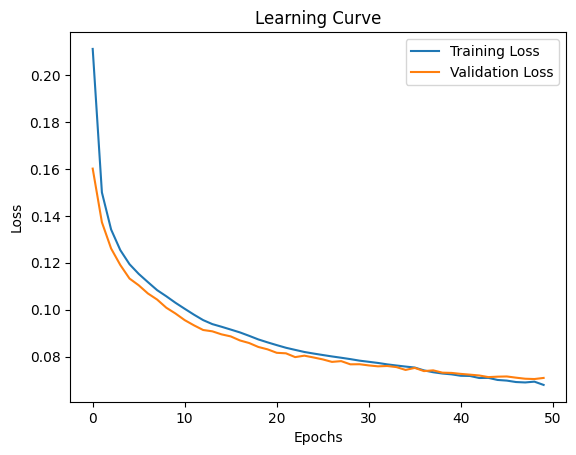

In [17]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.title("Learning Curve")
plt.show()

## Evaluation

In [18]:
X_pred = model.predict(X_val)
reconstruction_errors = np.mean(np.square(X_val - X_pred), axis=(1, 2))
anomaly_scores = reconstruction_errors / np.sum(reconstruction_errors)

741/741 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step


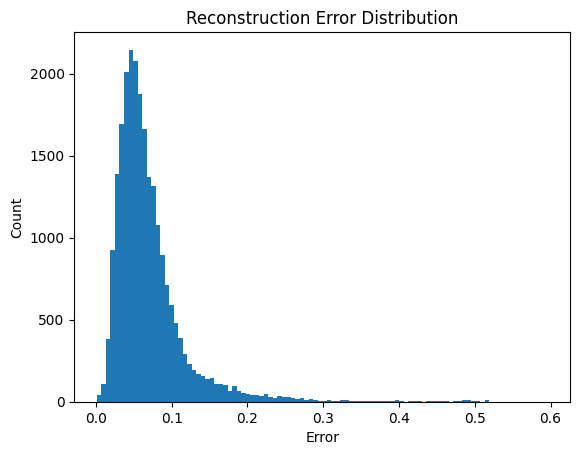

In [19]:
plt.hist(reconstruction_errors, bins=100)
plt.title("Reconstruction Error Distribution")
plt.xlabel("Error")
plt.ylabel("Count")
plt.show()

In [20]:
# Example threshold (manual or statistical)
threshold = np.percentile(reconstruction_errors, 99)
anomalies = reconstruction_errors > threshold
print(f"Detected {anomalies.sum()} anomalies in validation set")

Detected 237 anomalies in validation set


In [21]:
def plot_anomalies(errors, threshold):
    anomalies = errors > threshold
    plt.figure(figsize=(14, 3))
    plt.plot(errors, label="Reconstruction Error")
    plt.scatter(np.where(anomalies)[0], errors[anomalies], color='red', label='Anomalies')
    plt.axhline(threshold, color="r", linestyle="--", label="Threshold")
    plt.title("Detected Anomalies")
    plt.xlabel("Sample")
    plt.ylabel("Error")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

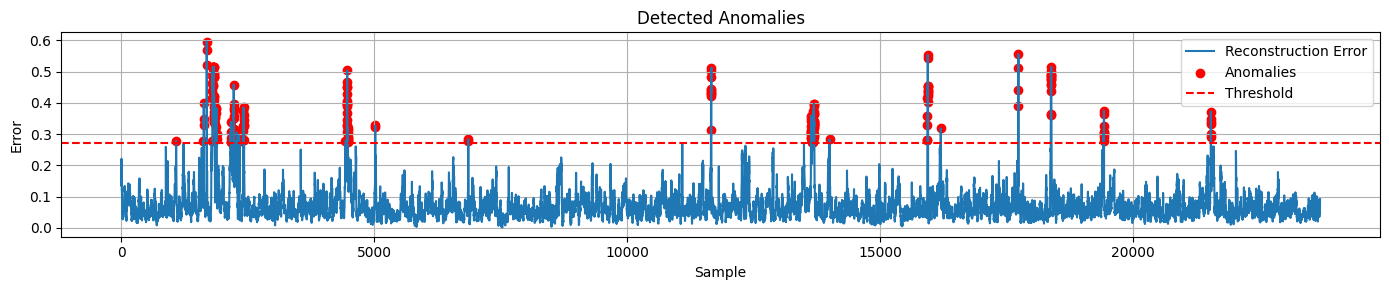

In [22]:
plot_anomalies(reconstruction_errors, threshold)

In [ ]:
from scipy.spatial.distance import mahalanobis

val_df = df.iloc[-23693:]
mean_vec = val_df.mean().values
cov_mat = np.cov(val_df.T)
inv_cov = np.linalg.inv(cov_mat)

distances = df.apply(lambda x: mahalanobis(x, mean_vec, inv_cov), axis=1)

In [ ]:
reconstruction_error_norm = (reconstruction_errors - reconstruction_errors.min()) / (reconstruction_errors.max() - reconstruction_errors.min())
mahalanobis_norm = (distances - distances.min()) / (distances.max() - distances.min())

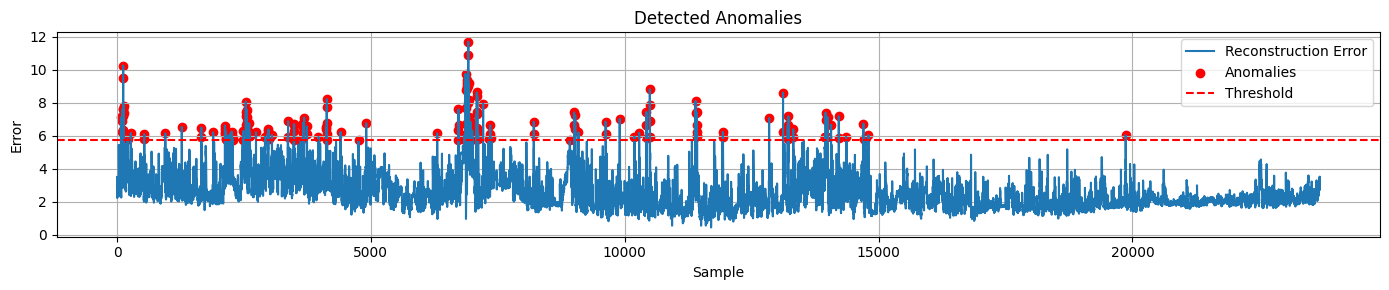

In [69]:
man_threshold = np.percentile(distances, 99)
plot_anomalies(distances, man_threshold)

In [41]:
from scipy.stats import skew, kurtosis

print(f"Skewedness: {skew(reconstruction_errors):.4f}")
print(f"Excess Kurtosis: {kurtosis(reconstruction_errors) - 3:.4f}")

Skewedness: 3.3971
Excess Kurtosis: 15.7210


## Saving and Logging Model

In [33]:
model_id = f"model_{datetime.now().strftime('%Y%m%d_%H%M')}"

hyperparams = {
    "window_size": WINDOW_SIZE,
    "batch_size": BATCH_SIZE,
    "epochs": EPOCHS,
    "learning_rate": 0.001,
    "optimizer": "adam",
    "loss_function":"mse"
}

save_model_metadata(history, model, model_id, hyperparams=hyperparams, callbacks=callbacks)
save_model_with_id(model, model_id)

Model saved to models\model_20250729_1455.keras
